Kimberly Adams 
DSC 530 September 2022

Download data files from github

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

# Download author's functions.
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
# Import numpy, pandas, and random packages
import numpy as np
import pandas as pd
import random

# Import author's functions
import thinkstats2
import thinkplot

In [29]:
# Import author's functions

class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()
    

class DiffMeansPermute(thinkstats2.HypothesisTest):
    # Shuffle the data to check for just a difference in mean between groups.
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    
class DiffMeansOneSided(DiffMeansPermute):
    # One-sided checked for a specific [smaller or larger] difference in mean.
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat
    
    
class DiffStdPermute(DiffMeansPermute):
    # Calculate differences in group standard deviations.
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat
    

class CorrelationPermute(thinkstats2.HypothesisTest):
    # Test if correlation is significant between two variables
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
    
class PregLengthTest(thinkstats2.HypothesisTest):
    # Chi-square test of pregnancy length    
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

# Chapter 9
### Excercise 9-1

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real. 

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

In [4]:
# Download NSFG data
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

# Import data
import first

What happens to the p-values of these tests as the sample size decreases?

In [50]:
def Tests(live, iters=1000):
    NumSamples = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # Permutation test: Compare pregnancy lengths for first and later children
    lendata = firsts.prglngth.values, others.prglngth.values
    HypoTest1 = DiffMeansPermute(lendata)
    P_value1 = HypoTest1.PValue(iters=iters)
    
    # Correlation: Pregnancy length and birth weight
    cleaned = live.dropna(subset=['prglngth', 'totalwgt_lb'])
    corrdata = cleaned.prglngth.values, cleaned.totalwgt_lb.values
    HypoTest2 = CorrelationPermute(corrdata)
    P_value2 = HypoTest2.PValue(iters=iters)

    # Correlation: Pregnancy age and birth weight
    cleaned2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    corrdata2 = cleaned2.agepreg.values, cleaned2.totalwgt_lb.values
    HypoTest3 = CorrelationPermute(corrdata2)
    P_value3 = HypoTest3.PValue(iters=iters)

    # Chi-square: Pregnancy length
    HypoTest4 = PregLengthTest(lendata)
    P_value4 = HypoTest4.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (NumSamples, P_value1, P_value2, P_value3, P_value4))
    # print("Samples=", NumSamples, "Perm p=", P_value1, "Corr p=", P_value2, "Chi p=", P_value3)

In [55]:
n = len(live)
for _ in range(8):
    sample = thinkstats2.SampleRows(live, n)
    Tests(sample)
    n //= 2

9148	0.15	0.00	0.00	0.00
4574	0.22	0.00	0.00	0.00
2287	0.13	0.00	0.00	0.00
1143	0.33	0.00	0.00	0.07
571	0.55	0.00	0.93	0.07
285	0.44	0.00	0.27	0.05
142	0.22	0.00	0.13	0.67
71	0.14	0.56	0.38	0.41


*Means difference: Looking at pregnancy length, as the sample size decreases, the p-value shows some increases but is very all over the place due to the randomness of the sample (2nd column).*

*Correlation (pregnancy length and birth weight): The  p-value remained at 0 the entire time until the very smallest sample (3rd column).* 

*Correlation (pregnancy age and birth weight): The p-value increased overall with decreasing sample size with a huge spike at n=571 (4th column).*

*Chi-square (pregnancy length): The p-value also increases with decreasing sample size (5th column).*

What is the smallest sample size that yields a positive test?

*Means difference: no sample sizes yielded a significant result*

*Correlation (pregnancy length and birth weight): All sample sizes yielded a significant result except n=71 (3rd column).* 

*Correlation (pregnancy age and birth weight): Sample sizes as low as n=1143 consistently yielded a significant p-value. (4th column).*

*Chi-square (pregnancy length): Lowest sample size with significant p-value is n=2287 (5th column).*

*Overall, a minimum value of n=1143 is needed to yield a significant p-value using a cut off value of 0.05.*

# Chapter 10
### Excercise 10-1

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height.

In [56]:
# Download data
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

# Import the data into dataframe
import brfss
df = brfss.ReadBrfss()

# Trim dataset to height and weight and drop rows with missing values.
df = df.dropna(subset=['htm3', 'wtkg2'])
height, weight = df.htm3, df.wtkg2

# Find log(weight)
logwgt = np.log10(weight)

In [57]:
# Import author's function to find linear least squares fit

from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [59]:
inter, slope = LeastSquares(height, logwgt)
inter, slope

(0.9930804163918123, 0.005281454169417808)

How would you best present the estimated parameters for a model like this where one of the variables is log-transformed?

In [70]:
meanHeight = Mean(height)
wgt_meanHeight = 10 ** (inter + slope * Mean(height))
wgt_meanHeight / meanHeight

0.4546117735223071

*For each cm of height, a person gains roughly 0.45 kg of weight.*

In [60]:
# Import author's function to find the fitted line

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

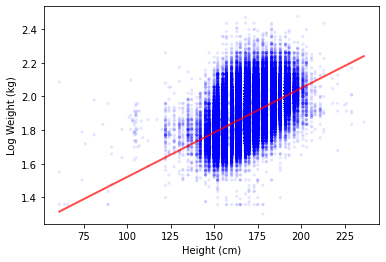

In [73]:
fit_xs, fit_ys = FitLine(height, inter, slope)

thinkplot.Scatter(height, logwgt, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Log Weight (kg)',
                 legend=False)

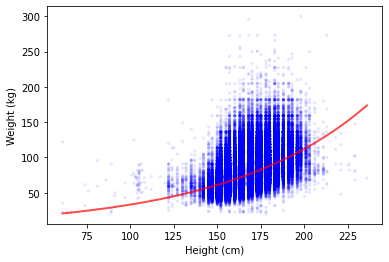

In [74]:
fit_xs, fit_ys = FitLine(height, inter, slope)

thinkplot.Scatter(height, weight, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Height (cm)",
                 ylabel='Weight (kg)',
                 legend=False)

If you were trying to guess someone’s weight, how much would it help to know their height? 

*Even without doing a log transformation, the fit line is almost linear so knowing the person's height would help with guessing the person's weight, but as you can see in the blue dot cloud, there is still a lot of variation.*

In [75]:
# Import author's function to calculate residuals
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [93]:
# Add residual column to dataframe
df['residual'] = Residuals(height, logwgt, inter, slope)

In [98]:
# Split the data into groups by height 
bins = np.arange(50, 250, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

# Calculate average height in each group
hgt_means = [group.htm3.mean() for _, group in groups][1:-1]

# Calculate CDF of the residuals of each group
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [96]:
# Import author's function to plot residual percentiles against average height within each group.
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

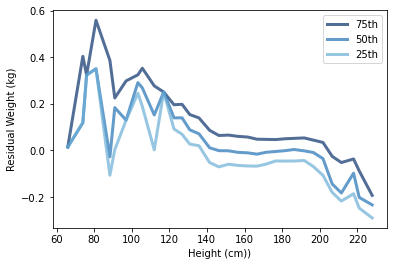

In [118]:
PlotPercentiles(hgt_means, cdfs)
    
thinkplot.Config(xlabel="Height (cm))",
                 ylabel='Residual Weight (kg)', legend=True)

*From this residuals graph it looks like we might be able to predict a log weight value if the person's height is between roughly 140-200 cm.  Outside of this range, the predictions become much less reliable as indicated by the jumping lines and the residual values moving away from zero.*

In [119]:
# Calculate correlation.
rho = thinkstats2.Corr(height, logwgt)

# Calculate coefficient of determination
# Compares residual variance to the dependent variable variance
r2 = 1 - Var(df.residual) / Var(logwgt)

# Confirm that correlation is equal to the coefficient of dertermination
np.isclose(rho**2, r2)

True

In [125]:
# Calculate Std(ys) - doesn't use height
std_ys = thinkstats2.Std(logwgt)
print(std_ys, "Without height")

# Calculate Std(res) - uses height
std_res = thinkstats2.Std(df.residual)
print(std_res, "With height")

# How much does height improve Root Means Squared Error?
(1 - (std_res / std_ys))*100

0.10320725030004894 Without height
0.0874077708041609 With height


15.308497658793407

*Including the height reduces the RMSE by roughly 15.3% and thus is usful in our prediction.*

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate: 
- the mean height of respondents in the BRFSS, 
- the standard error of the mean, and 
- a 90% confidence interval.

In [142]:
# Import author's functions
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample


def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)


def SamplingDistributions(live, iters=101):
    # Returns lists of estimates of intercept and slope.
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes


def Summarize(estimates, actual=None):
    # Returns mean, standard error, and 90% confidence interval.
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean=', mean)
    print('SE=', stderr)
    print('CI=', ci)
    
    
def ResampleRowsWeighted(df, column='finalwgt'):
    # Resamples rows with probabilities proportional to weights
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [146]:
# Calculated summary statistics for unweighted data
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
print('Unweighted:')
Summarize(estimates_unweighted)

# Calculated summary statistics for weighted data using the finalwt column
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
print('\n Weighted:')
Summarize(estimates_weighted)

Unweighted:
mean= 168.95477465187253
SE= 0.015504884260857048
CI= (168.9291820772449, 168.97875108631945)

 Weighted:
mean= 170.49656245578933
SE= 0.01587537418656807
CI= (170.46902473776754, 170.52425523959658)


How much does correct weighting affect the estimates?

*The unweighted mean is just under 2 cm shorter than the weighted mean. The standard error is ever so slighlty smaller in the unweighted scenario, but is still significantly less than the value of the difference between the means.  Also the confidence intervals as narrower int he unweighted scenario.*